# Data

In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip -qq PennFudanPed.zip

--2024-03-07 06:54:21--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  26.6MB/s    in 1.9s    

2024-03-07 06:54:23 (26.6 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]



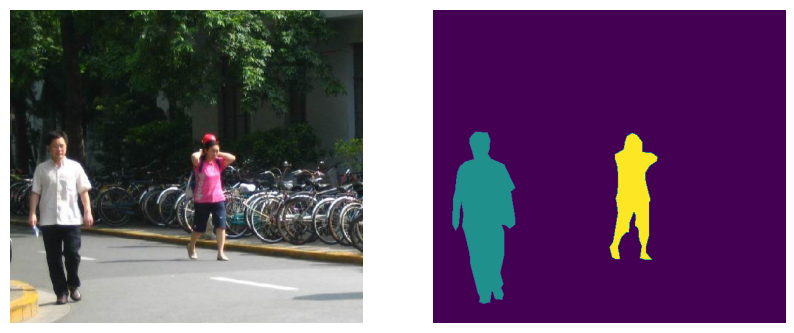

In [2]:
import torch
import numpy as np
import os
import sys
import torchvision
import pandas as pd
import matplotlib.pyplot as plt


from pprint import pprint
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

image = read_image('/content/data/PennFudanPed/PNGImages/FudanPed00050.png')
mask = read_image('/content/data/PennFudanPed/PedMasks/FudanPed00050_mask.png')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.permute(1, 2, 0))
ax[1].imshow(mask.permute(1, 2, 0))
ax[0].axis('off')
ax[1].axis('off')
plt.show()



```
Shape of image: N x H x W
Shape of mask: 1 x H x W
```



In [3]:
from collections import Counter
Counter(torch.flatten(mask).numpy())

Counter({0: 273163, 1: 17473, 2: 8644})

# Dataset

In [4]:
class PennFudanPed(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        image = read_image(img_path)

        mask = read_image(os.path.join(self.root, "PedMasks", self.masks[idx]))

        # number of instances per image
        obj_ids = torch.unique(mask)

        # the first class index is the background; hence discard it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # convert to binary mask per object. Shape of the
        # following: N x height x width (with elements 0 and 1)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding boxes for each mask, shape = N x 4
        # Coordinates: (x1, y1, x2, y2)
        boxes = masks_to_boxes(masks)

        # we only have a single class which is pedestrian
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # compute all other fields required for the annotaion
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(image)
        target = {
            'image_id': idx,
            'boxes': tv_tensors.BoundingBoxes(boxes,
                                              format="XYXY",
                                              canvas_size=F.get_size(img)),
            'masks': tv_tensors.Mask(masks),
            'labels': labels,
            'area': area,
            "iscrowd": iscrowd,

            # extra
            "img_path": img_path,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Model builder

In [5]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [6]:
def get_model_instance_segmentation(num_classes):
    # load a pretrained instance segmentation model (MaskRCNN) on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # pedestrian + background
    num_classes = 2

    # number of input features for the last layer of the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pretrined COCO box prediction head with our custom 2 class head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # replace the mask predictor with custom mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask,
                                                       dim_reduced=hidden_layer,
                                                       num_classes=num_classes)
    return model

# Sanity check

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
from torchvision.transforms import v2 as T


def get_transform(train: bool):
    """
    image augmentation transforms. The transformations also take care
    that the bounding boxes are changed appropriately. For more details refer to
    https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors
    """

    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [9]:
# The aim of the `collate_fn` is to obtain a `batch` and produce a new `batch`
# that can be consumed by the model. In our case each item of the batch is
# (image, target) as produced by the dataset[idx] call.
# def collate_fn(batch):
#     images = torch.stack([item[0] for item in batch])
#     targets = [item[1] for item in batch]
#     return images, targets

def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
dataset = PennFudanPed(root='/content/data/PennFudanPed',
                       transforms=get_transform(train=False))

# for sanity check purposes we will use the base COCO pretrained faster-RCNN model
# Note: this model "does not" contain the mask head.
base_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
_ = base_model.to(device)

train_dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 160MB/s]


In [11]:
images, targets = next(iter(train_dataloader))

Given the `collate_fn` that we used, a call to the dataloader will return a batch that will consists of a tuple of two variables: images and targets. The variable `images` will be a tuple of image tensors, the length of the tuple being `batch_size`, while the variable targets will be a tuple of target annotations of the same size.

In [12]:
images = list(image.to(device) for image in images)
targets = [{k : v.to(device) if isinstance(v, torch.Tensor) else v
            for k, v in t.items()} for t in targets]

In [13]:
# feed through the model
outputs = base_model(images, targets)
pprint(outputs)

{'loss_box_reg': tensor(0.0608, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.2419, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.0483, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)}


In [14]:
with torch.no_grad():
    base_model.eval()
    predictions = base_model(images)

In [15]:
predictions[0]

{'boxes': tensor([[1.9247e+01, 5.7336e+01, 1.1127e+02, 3.2277e+02],
         [3.1780e+02, 1.9573e+01, 4.1867e+02, 3.1600e+02],
         [4.1947e+02, 6.1308e+01, 4.4299e+02, 1.2077e+02],
         [8.3319e+01, 8.6354e+01, 1.3785e+02, 1.1682e+02],
         [2.2314e+02, 8.6937e+01, 2.6017e+02, 1.3452e+02],
         [3.1928e-01, 1.0525e+02, 3.2779e+01, 2.0543e+02],
         [8.9522e-02, 8.7794e+01, 3.8319e+01, 1.1977e+02],
         [1.2926e+02, 7.1195e+01, 2.3198e+02, 1.4726e+02],
         [4.4788e+02, 6.3186e+01, 4.5995e+02, 1.1057e+02],
         [2.1905e+00, 1.0937e+02, 1.3533e+02, 2.0360e+02],
         [3.9731e+01, 8.9826e+01, 5.3628e+01, 1.0528e+02],
         [4.3922e+02, 7.3010e+01, 4.4834e+02, 1.0085e+02],
         [1.0015e+02, 1.1200e+02, 1.3165e+02, 1.8903e+02],
         [1.3281e+02, 6.8764e+01, 2.2905e+02, 1.4629e+02],
         [1.2879e+02, 8.3621e+01, 1.3941e+02, 9.4668e+01],
         [8.4500e+01, 9.0678e+01, 1.3768e+02, 1.8499e+02],
         [3.2158e+02, 1.6800e+02, 3.3802e+02, 1

In [16]:
from PIL import Image


def plot_results(pil_image, probas, boxes) -> None:
    _, ax = plt.subplots()
    ax.imshow(pil_image)

    for p, (xmin, ymin, xmax, ymax) in zip(probas, boxes):
        ax.add_patch(plt.Rectangle(xy=(xmin, ymin),
                                   height=ymax-ymin,
                                   width=xmax-xmin, fill=False, color='yellow'))

    plt.axis('off')
    plt.show()

def plot_prediction(target, prediction, threshold=0.8):
    # load image using PIL
    image = Image.open(target['img_path'])

    # only keep significant detections
    keep = prediction['scores'] > threshold

    plot_results(image, probas=prediction['scores'][keep].cpu().numpy(),
                 boxes=prediction['boxes'][keep].cpu().numpy())

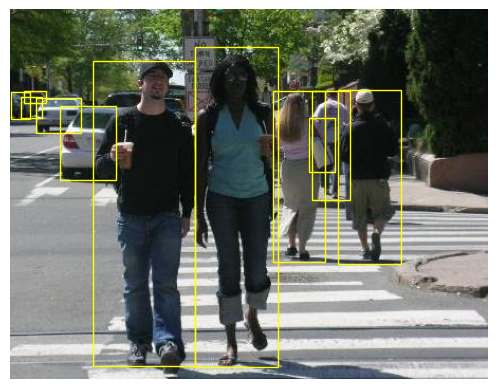

In [17]:
plot_prediction(targets[1], predictions[1])

# Dataloaders

In [60]:
print("Number of training samples: ", len(dataset_train))
print("Number of test samples: ", len(dataset_test))

dataset_train = PennFudanPed(root='/content/data/PennFudanPed',
                       transforms=get_transform(train=True))
dataset_test = PennFudanPed(root='/content/data/PennFudanPed',
                       transforms=get_transform(train=False))

# train test split
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices=indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices=indices[-50:])

# define dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=2,
                                               shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                             shuffle=False, collate_fn=collate_fn)

Number of training samples:  120
Number of test samples:  50


# Model

In [20]:
# for model development
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 36.5 MB/s eta 0:00:00


In [21]:
# for evaluation
!pip install -q pycocotools

In [22]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [62]:
# required imports for this section
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
from tqdm import tqdm

In [63]:
class CustomModel(pl.LightningModule):
    def __init__(self, num_classes, lr, weight_decay):
        super().__init__()
        self.num_classes = num_classes
        self.lr = lr
        self.weight_decay = weight_decay

        self.backbone = get_model_instance_segmentation(self.num_classes)
        self.coco_evaluator = None

    def forward(self, images):
        outputs = self.backbone(images)
        return outputs

    def custom_forward(self, batch, batch_idx):
        images, targets = batch

        # move to device
        images = list(image.to(self.device) for image in images)
        targets = [{k : v.to(self.device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()} for t in targets]

        # feed forward
        loss_dict = self.backbone(images, targets=targets)
        total_loss = sum(loss for loss in loss_dict.values())

        return total_loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.custom_forward(batch, batch_idx)
        self.log("training_loss", loss, prog_bar=True)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    # def validation_step(self, batch, batch_idx):
    #     loss, loss_dict = self.custom_forward(batch, batch_idx)
    #     self.log("validation_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                      weight_decay=self.weight_decay)
        return optimizer

In [64]:
pl_model = CustomModel(num_classes=2, lr=1e-4, weight_decay=1e-4)

In [66]:
trainer = Trainer(max_epochs=5, accelerator="gpu")
trainer.fit(pl_model, train_dataloaders=train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type     | Params
--------------------------------------
0 | backbone | MaskRCNN | 43.9 M
--------------------------------------
43.7 M    Trainable params
222 K     Non-trainable params
43.9 M    Total params
175.690   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLo

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Evaluation

In [69]:
# construct coco_evaluator for getting mAP and mAR
coco = get_coco_api_from_dataset(test_dataloader.dataset)
coco_evaluator = CocoEvaluator(coco, ['bbox', 'segm'])

creating index...
index created!


In [70]:
# put model in eval mode for testing
pl_model.to(device)
pl_model.eval()

for idx, batch in enumerate(tqdm(test_dataloader)):
    images, targets = batch
    images = list(image.to(device) for image in images)

    # get predictions
    outputs = pl_model.backbone(images)
    outputs = [{k : v.cpu() for k, v in output.items()} for output in outputs]

    res = {
        target['image_id']: output for (target, output) in zip(targets, outputs)
    }
    coco_evaluator.update(res)


100%|██████████| 50/50 [00:06<00:00,  7.45it/s]


In [71]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.762

# Visualization

In [72]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image

In [73]:
def draw_prediction(image, target, threshold=0.8):
    # get model result
    outputs = pl_model(image.unsqueeze(0))  # add batch dimension
    outputs = outputs[0]

    # get original image
    image = read_image(target['img_path'])
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]

    # only keep high probabaility detections
    keep = outputs['scores'] > threshold

    # draw bounding boxes
    pred_labels = [f"pedestrian: {score:.3f}" for label, score in
                zip(outputs["labels"][keep], outputs["scores"][keep])]
    output_image = draw_bounding_boxes(image,
                                    outputs['boxes'][keep],
                                    pred_labels,
                                    colors="white")

    # add instance segmentation masks
    masks = (outputs["masks"][keep] > 0.7).squeeze(1)
    output_image = draw_segmentation_masks(output_image, masks,
                                           alpha=0.5, colors='blue')


    plt.imshow(output_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [74]:
test_dataloader_iter = iter(test_dataloader)

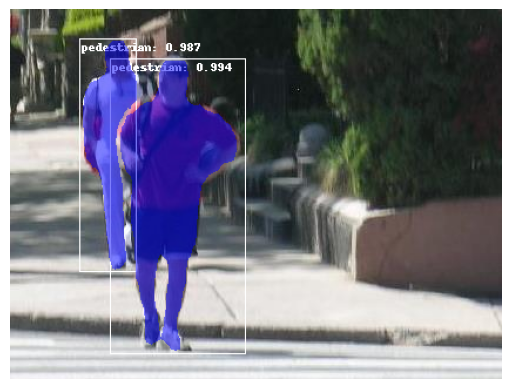

In [78]:
image, target = dataset_test[42]

draw_prediction(image.to(device), target)